In [175]:
import cv2
import tensorflow as tf

from IPython import display

In [142]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE
PATH = '../'

In [143]:
BUFFER_SIZE = 2000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [144]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.reduce_max(image, axis=-1, keepdims=True)
    return image

In [145]:
train_dataset_1 = tf.data.Dataset.list_files(str(PATH + 'resources/data/class_test/Carattere-Regular/*.jpg'),shuffle=BUFFER_SIZE).map(load, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
train_dataset_2 = tf.data.Dataset.list_files(str(PATH + 'resources/data/class_test/SingleDay-Regular/*.jpg'),shuffle=BUFFER_SIZE).map(load, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

train_size_1 = int(0.9 * train_dataset_1.cardinality().numpy())
train_size_2 = int(0.9 * train_dataset_2.cardinality().numpy())
test_dataset_1 = train_dataset_1.skip(train_size_1)
train_dataset_1 = train_dataset_1.take(train_size_1)
test_dataset_2 = train_dataset_2.skip(train_size_2)
train_dataset_2 = train_dataset_2.take(train_size_2)

(len(train_dataset_1), len(test_dataset_1), len(train_dataset_2), len(test_dataset_2))

(1800, 201, 1800, 201)

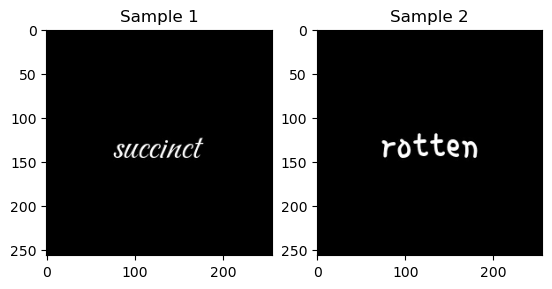

In [146]:
sample_1 = next(iter(train_dataset_1))
sample_2 = next(iter(train_dataset_2))

plt.subplot(121)
plt.title('Sample 1')
plt.imshow(sample_1[0] * 0.5 + 0.5, cmap='gray')

plt.subplot(122)
plt.title('Sample 2')
plt.imshow(sample_2[0] * 0.5 + 0.5, cmap='gray')

In [147]:
OUTPUT_CHANNELS = 1

In [148]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self):
    super(InstanceNormalization, self).__init__()
    self.epsilon = 1e-5

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset
  
  @classmethod
  def from_config(cls, config):
      return InstanceNormalization()

In [149]:
def downsample(filters, size, apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [150]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(InstanceNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [151]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, OUTPUT_CHANNELS])

  down_stack = [
    downsample(64, 4, apply_norm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 1)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [152]:
def Discriminator(target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).

  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.

  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, OUTPUT_CHANNELS], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, OUTPUT_CHANNELS], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  
  norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

In [153]:


generator_g = Generator()
generator_f = Generator()

discriminator_x = Discriminator(target=False)
discriminator_y = Discriminator(target=False)

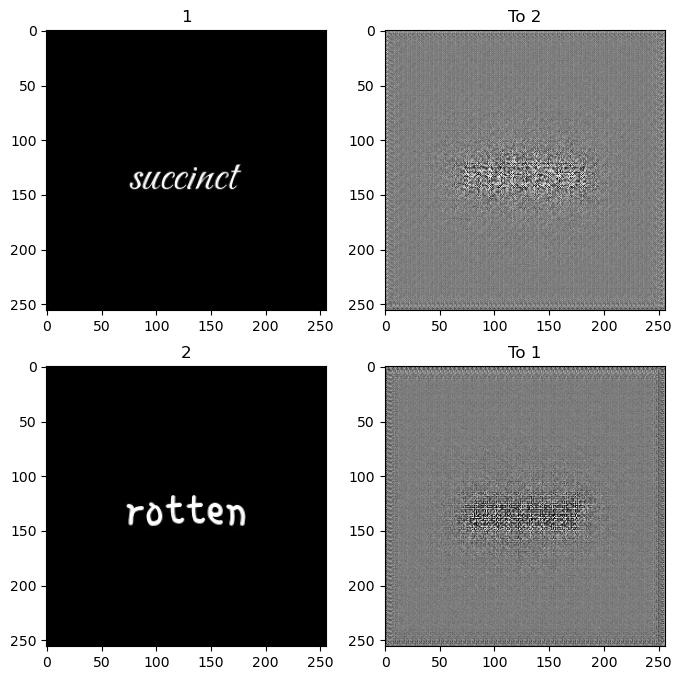

In [154]:
to_1 = generator_g(sample_1) #horse
to_2 = generator_f(sample_2)

plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_1, to_2, sample_2, to_1]
title = ['1', 'To 2', '2', 'To 1']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5, cmap='gray')
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

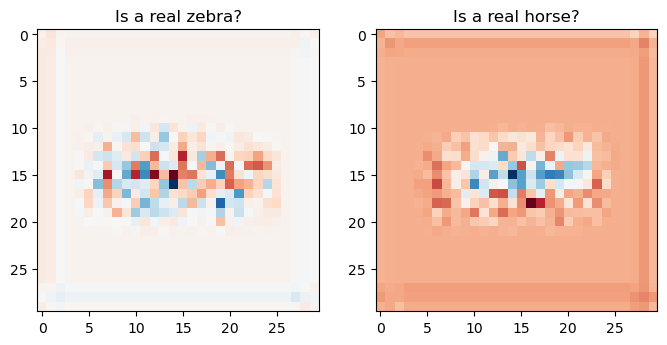

In [155]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_2)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_1)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [156]:
LAMBDA = 10

In [157]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [158]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [159]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [160]:
semantic_disc = tf.keras.models.load_model('../models/semantic-word-discriminator-256x256.keras',custom_objects={'InstanceNormalization':InstanceNormalization})

In [161]:
def calc_cycle_loss(real_image, cycled_image):
  loss2 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  loss = -semantic_disc([real_image,cycled_image])[0][0]
  loss = loss if loss>0.0 else 0.0
  return LAMBDA * loss2 + 20*loss

In [162]:
def identity_loss(real_image, same_image):
  loss2 = tf.reduce_mean(tf.abs(real_image - same_image))
  loss = -semantic_disc([real_image,same_image])[0][0]
  loss = loss if loss>0.0 else 0.0
  return LAMBDA * 0.5 * loss2 + 20*loss

In [163]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [191]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(4, 4))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    #plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
  plt.show()

In [165]:
import datetime

log_dir = "../logs_cyclegan/"

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
x_log_dir = log_dir + current_time + 'x'
y_log_dir = log_dir + current_time + 'y'
x_summary_writer = tf.summary.create_file_writer(x_log_dir)
y_summary_writer = tf.summary.create_file_writer(y_log_dir)


In [166]:
@tf.function
def train_step(real_x, real_y, step):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    cycle_loss_x = calc_cycle_loss(real_x, cycled_x) 
    cycle_loss_y = calc_cycle_loss(real_y, cycled_y)
    total_cycle_loss = cycle_loss_x + cycle_loss_y

    identity_loss_x = identity_loss(real_x, same_x)
    identity_loss_y = identity_loss(real_y, same_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss_y
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss_x

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
      
    with x_summary_writer.as_default():
        tf.summary.scalar('cycle_loss', cycle_loss_x, step=step//10)
        tf.summary.scalar('gen_loss', gen_f_loss, step=step//10)
        tf.summary.scalar('identity_loss', identity_loss_x, step=step//10)
        tf.summary.scalar('disc_loss', disc_x_loss, step=step//10)
        
    with y_summary_writer.as_default():
        tf.summary.scalar('cycle_loss', cycle_loss_y, step=step//10)
        tf.summary.scalar('gen_loss', gen_g_loss, step=step//10)
        tf.summary.scalar('identity_loss', identity_loss_y, step=step//10)
        tf.summary.scalar('disc_loss', disc_y_loss, step=step//10)


  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [27]:
from tensorboard import notebook

notebook.list()  # View open TensorBoard instances


Known TensorBoard instances:
  - port 6007: logdir ../logs_cyclegan/ (started 2 days, 2:11:34 ago; pid 11436)
  - port 6008: logdir ../logs_cyclegan/ (started 2 days, 2:06:09 ago; pid 11648)
  - port 6006: logdir ../logs/fit/ (started 5 days, 2:12:03 ago; pid 16700)
  - port 6009: logdir ../logs_cyclegan/ (started 2 days, 1:52:05 ago; pid 1940)
  - port 6006: logdir ../logs/fit (started 5 days, 2:17:24 ago; pid 1964)
  - port 6006: logdir ../logs/ (started 5 days, 3:00:09 ago; pid 22464)
  - port 6006: logdir ../logs/fit (started 5 days, 2:16:40 ago; pid 8424)


In [29]:
notebook.start("--logdir="+log_dir+" --port 6010")
notebook.display(port=6010, height=1000)

Launching TensorBoard...

Selecting TensorBoard with logdir ../logs_cyclegan/ (started 0:00:00 ago; port 6010, pid 26240).


In [167]:
def mod(x, y):
    return x - y * (x // y)

Time taken for 10 steps: 3.81 sec


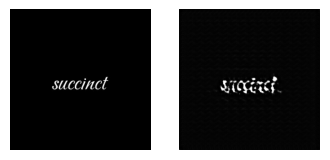

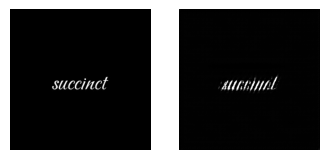

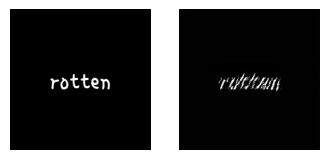

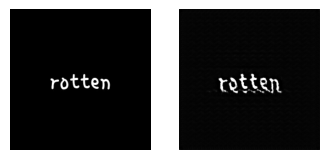

Step: 130
.

KeyboardInterrupt: 

In [192]:
steps = 40000

start = time.time()
for step, (image_x, image_y) in tf.data.Dataset.zip((train_dataset_1, train_dataset_2)).repeat().take(steps).enumerate():

    if mod(step,10) == 0:
        display.clear_output(wait=True)
    
        if step != 0:
            print(f'Time taken for 10 steps: {time.time()-start:.2f} sec\n')
            start = time.time()
            generate_images(generator_g, sample_1)
            generate_images(generator_f, sample_1)
            generate_images(generator_f, sample_2)
            generate_images(generator_g, sample_2)
            print(f"Step: {step}")
    
    train_step(image_x, image_y,step)
    # Training step
    if mod(step+1,2) == 0:
        print('.', end='', flush=True)



In [178]:
sample_1.numpy()

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]]], dtype=float32)

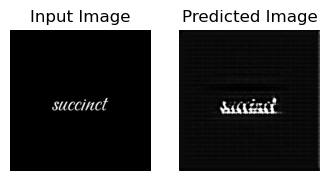

In [189]:

generate_images(generator_g, sample_1)

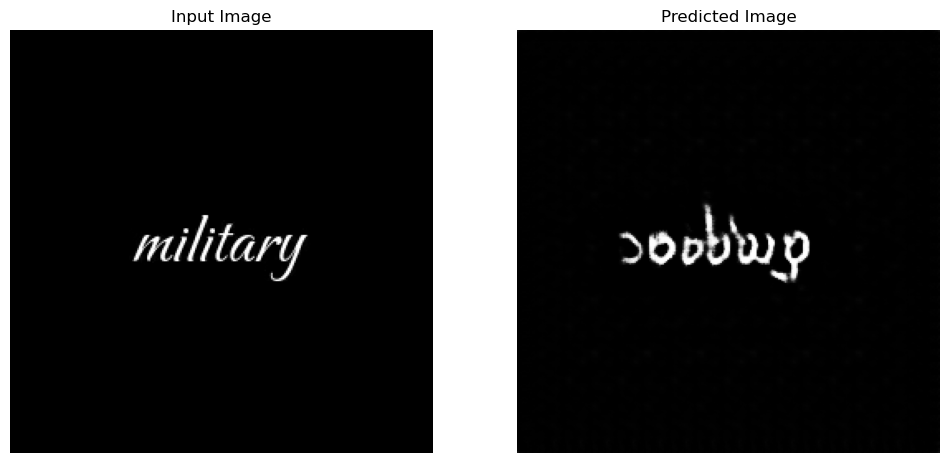

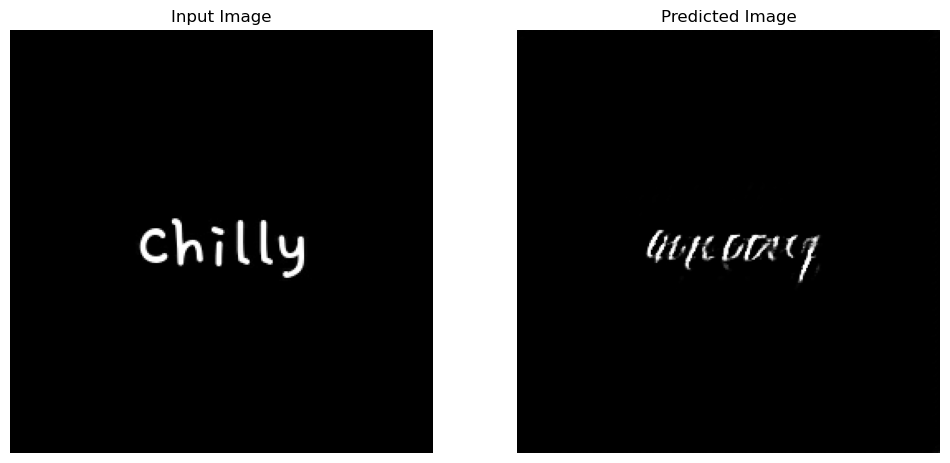

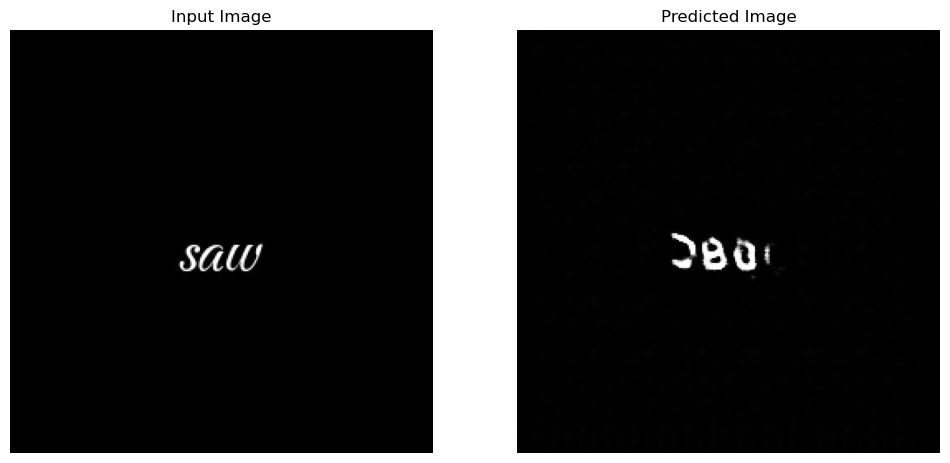

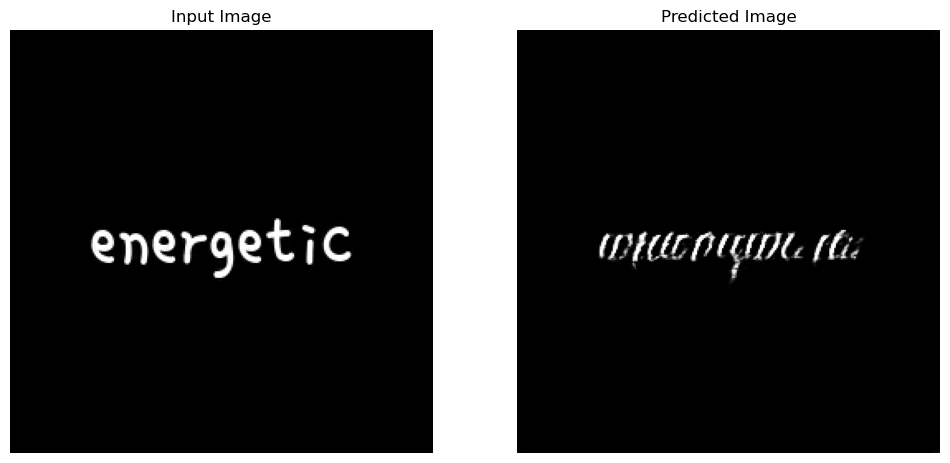

In [67]:
# Run the trained model on the test dataset
for (inp1,inp2) in tf.data.Dataset.zip((test_dataset_1,test_dataset_2)).take(2):
  generate_images(generator_g, inp1)
  generate_images(generator_f, inp2)

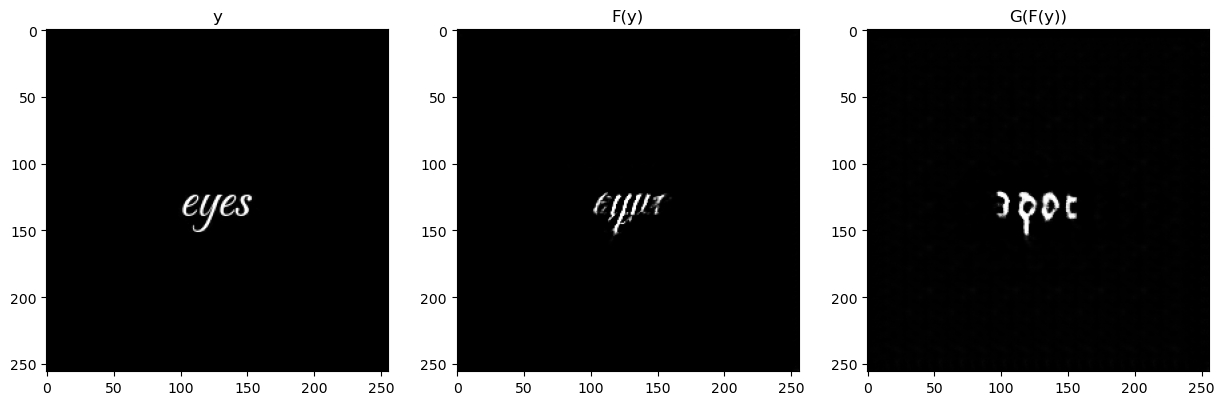

In [85]:
plt.figure(figsize=(15, 8))

to_1 = generator_f(sample_1)
imgs = [sample_1, to_1, generator_g(to_1)]
title = ['y', 'F(y)', 'G(F(y))']

for i in range(len(imgs)):
  plt.subplot(1, 3, i+1)
  plt.title(title[i])
  plt.imshow(imgs[i][0] * 0.5 + 0.5, cmap='gray')
plt.show()